**计算splicing patterns**

In [204]:
from collections import defaultdict, namedtuple, Counter
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import pyranges as pr
import pysam

from scipy.stats import variation, gaussian_kde, pearsonr, mannwhitneyu

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(filename)s: %(message)s',
                    datefmt='%m/%d/%Y %I:%M:%S %p',
                    )

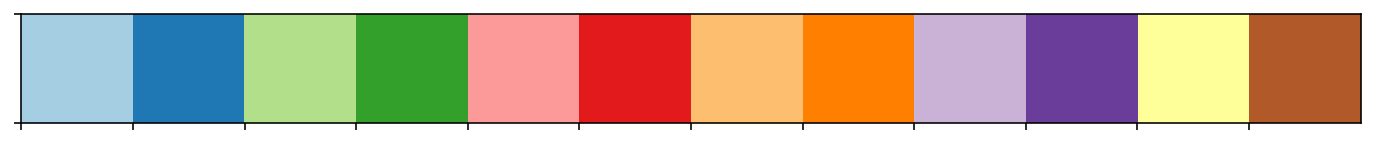

In [457]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
pal = sns.color_palette("Paired")
sns.set_palette(pal)
sns.palplot(pal)

# load data

## load gene model

In [4]:
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head()

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3629,5899,.,+
AT1G01020,1,6786,9130,.,-
AT1G03987,1,11099,11372,.,+
AT1G01030,1,11647,13714,.,-
AT1G01040,1,23119,31227,.,+


## load representative gene model

In [5]:
# 读取代表性转录本gene_model
araport11_isoform_path = '/public/home/mowp/db/Arabidopsis_thaliana/representative_gene_model/araport11.representative.gene_model.bed'
araport11_isoform = pr.read_bed(araport11_isoform_path, as_df=True)

araport11_isoform['gene_id'] = araport11_isoform['Name'].map(lambda x: x.split('.')[0])
araport11_isoform.set_index('gene_id', inplace=True)

araport11_isoform['BlockSizes'] = araport11_isoform['BlockSizes'].map(lambda x: np.fromstring(x, sep=',', dtype='int'))
araport11_isoform['BlockStarts'] = araport11_isoform['BlockStarts'].map(lambda x: np.fromstring(x, sep=',', dtype='int'))

# get_splicing_kinetics

In [7]:
Splice_stats = namedtuple('Splice_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

splice_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.ir_stats.tsv'

with open(splice_stats_pkl+'.pkl', 'rb') as f:
    splice_stats_dict = pickle.load(f)

In [ ]:
splice_stats_dict

In [20]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_splicing_kinetics(infile, gene_id):
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id, :].values
    gene_strand = STRAND_TO_BOOL[gene_strand]
    
    spliced_ratio = defaultdict(lambda : Counter())
    n = 0
    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            try:
                _, intron_count, unsplice_count, unsplice_intron  = splice_stats_dict[read.query_name][gene_id]
                if intron_count == 0:
                    # 转录还没有过第一个exon的情况
                    # 忽略
                    continue
            except KeyError:
                continue
            
            polya_len = read.get_tag('pa')
            gap = read.get_tag('ga')
            read_gene_id = read.get_tag('gi')
            
            if read_gene_id != gene_id:
                continue
            
            if read.is_reverse is gene_strand:
                if gene_strand:
                    five_end = read.reference_end*-1
                    three_end = read.reference_start*-1
                    # 获取基因3'SS位置
                    item = araport11_isoform.loc[gene_id, :]
                    three_ss = item.Start+item.BlockStarts[:-1]+item.BlockSizes[:-1]
                    three_ss = three_ss[::-1]*-1
                else:
                    five_end = read.reference_start
                    three_end = read.reference_end
                    # 获取基因3'SS位置
                    item = araport11_isoform.loc[gene_id, :]
                    three_ss = item.Start+item.BlockStarts[1:]
                
                # 未剪切的intron号
                unsplice_intron = set(np.fromstring(unsplice_intron, sep=',', dtype='int')) 
                # distance from 3'SS
                distance_list = three_end - three_ss[:intron_count]
                
                for intron_num, distance in enumerate(distance_list, 1):
                    if distance < 0:
                        logging.info(f'{gene_id}, {read.query_name}')
                        continue
                    if intron_num in unsplice_intron:
                        spliced_ratio[distance]['unspliced'] += 1
                    else:
                        spliced_ratio[distance]['spliced'] += 1

    return dict(spliced_ratio)

## Nanopore total RNA

In [255]:
IR_stats = namedtuple('IR_stats', 'intron_total_count intron_count unsplice_count unsplice_intron')

ir_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.ir_stats.tsv.pkl'

with open(ir_stats_pkl, 'rb') as f:
    ir_stats_dict = pickle.load(f)

In [22]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_splicing_kinetics, infile, gene_id))

In [23]:
spliced_ratio = defaultdict(lambda : Counter())

bw = 25
for res in results:
    result = res.result()
    for distance in result:
        _distance = (distance//bw+1) * bw
        spliced_ratio[_distance] += result[distance]

In [24]:
x = []
y = []
for distance in spliced_ratio:
    x.append(distance)
    y.append(spliced_ratio[distance]['spliced']/(spliced_ratio[distance]['spliced']+spliced_ratio[distance]['unspliced']))

In [26]:
nanopore_splicing = pd.DataFrame([x, y]).T
nanopore_splicing.sort_values(0, inplace=True)

Text(0.5, 0, 'Distance from 3′ SS (nt)')

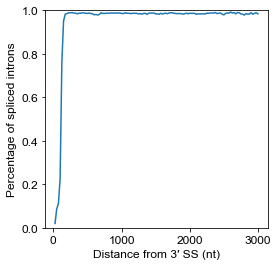

In [27]:
plt.figure(figsize=(4, 4))
xlim = 3000
plt.plot(nanopore_splicing[0][nanopore_splicing[0]<=xlim], nanopore_splicing[1][nanopore_splicing[0]<=xlim])
plt.ylim(0, 1)
plt.ylabel('Percentage of spliced introns')
plt.xlabel('Distance from 3′ SS (nt)')

In [30]:
splice_stats_dict['7630665e-c2ca-4b8d-a6d7-2240d68f8844']

{'AT1G01010': Splice_stats(intron_total_count=5, intron_count=5, unsplice_count=0, unsplice_intron='')}

# polya tail length in IR

In [34]:
infile = 'polya_length/nanopore_polya_len.tsv'
nanopore_polya = pd.read_csv(infile, sep='\t',)

In [392]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_IR_read_polya_len(infile, gene_id, mode='median'):
    '''
    获取同一基因不同剪切状态的polya长度
        fully_spliced
        unspliced
    '''
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id, :].values
    gene_strand = STRAND_TO_BOOL[gene_strand]
    unspliced_polya_len, spliced_polya_len = [], []

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            try:
                _, intron_count, unspliced_count, unspliced_intron  = ir_stats_dict[read.query_name][gene_id]
                if intron_count == 0:
                    # 转录还没有过第一个exon的情况
                    # 忽略
                    continue
            except KeyError:
                continue
            
            polya_len = read.get_tag('pa')
            read_gene_id = read.get_tag('gi')
            
            if read_gene_id != gene_id:
                continue
            
            if unspliced_count > 0:
                unspliced_polya_len.append(polya_len)
            else:
                spliced_polya_len.append(polya_len)
            
        if len(unspliced_polya_len) >= 5 and len(spliced_polya_len) >= 5:
            if mode == 'median':
                unspliced_count = len(unspliced_polya_len)
                spliced_count = len(spliced_polya_len)
                p_value = mannwhitneyu(unspliced_polya_len, spliced_polya_len)
                unspliced_polya_len = np.median(unspliced_polya_len)
                spliced_polya_len = np.median(spliced_polya_len)
                return unspliced_polya_len, unspliced_count, spliced_polya_len, spliced_count, p_value[1], gene_id

            elif mode == 'raw':
                return unspliced_polya_len, spliced_polya_len, gene_id

In [393]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
gene_id = 'AT1G01920'
get_IR_read_polya_len(infile, gene_id)

(232.625, 14, 113.67000198364258, 32, 4.7465234514405955e-05, 'AT1G01920')

In [394]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
gene_id = 'AT5G67110'
get_IR_read_polya_len(infile, gene_id)

(173.05999755859375,
 59,
 104.08000183105469,
 191,
 1.0051995707555749e-13,
 'AT5G67110')

In [395]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_IR_read_polya_len, infile, gene_id))

In [396]:
spliced_polya = []
for res in results:
    result = res.result()
    if result is not None:
        spliced_polya.append(result)

In [397]:
spliced_polya = pd.DataFrame(
    spliced_polya, 
    columns=['unspliced_polya_len', 'unspliced_count', 'spliced_polya_len', 'spliced_count', 'p_value', 'gene_id']
)

In [453]:
spliced_polya

,unspliced_polya_len,unspliced_count,spliced_polya_len,spliced_count,p_value,gene_id
0,201.785004,34,166.014999,38,6.438083e-03,AT1G01020
1,158.809998,9,96.074997,328,1.358551e-03,AT1G01050
2,126.654999,24,99.470001,134,1.384150e-02,AT1G01080
3,155.434998,16,82.419998,1895,5.347263e-07,AT1G01100
4,165.385002,6,128.435001,42,1.636344e-02,AT1G01140
...,...,...,...,...,...,...
4211,129.415001,12,110.279999,143,3.998850e-02,AT5G67480
4212,189.105003,6,114.055000,58,2.223815e-03,AT5G67580
4213,172.095001,12,86.330002,646,2.974486e-06,AT5G67590
4214,147.805000,20,89.070000,503,1.269859e-07,AT5G67600


In [454]:
spliced_polya['color'] = spliced_polya['p_value'].map(lambda x: 1 if x < .01 else 0)

Text(0.5, 1.0, 'Median poly(A) tail (nt)')

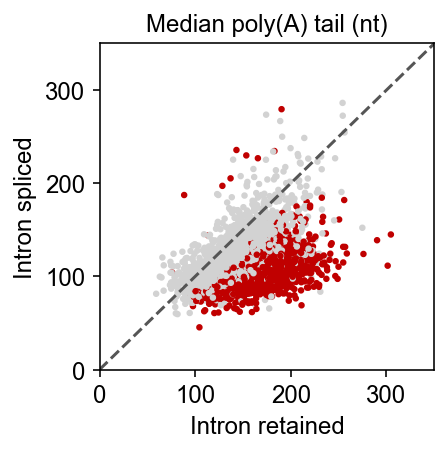

In [489]:
# CR-APA

plt.figure(figsize=(3, 3))
plt.scatter(
    x=spliced_polya['unspliced_polya_len'], 
    y=spliced_polya['spliced_polya_len'], 
    s=5, 
    c=spliced_polya['color'],
    cmap=mpl.colors.ListedColormap(['#D2D2D2', '#C00000']),
)
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.plot([0, 350], [0, 350], color='#555555', ls='--')
plt.xlabel('Intron retained')
plt.ylabel('Intron spliced')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

plt.title('Median poly(A) tail (nt)', size='medium')

/public/home/mowp/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
11/05/2020 07:24:43 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b0332cee950>
11/05/2020 07:24:43 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b0332cee950> on colorbar
11/05/2020 07:24:43 PM colorbar.py: Setting pcolormesh
11/05/2020 07:24:43 PM colorbar.py: locator: <matplotlib.ticker.FixedLocator object at 0x2b03ce929d90>
11/05/2020 07:24:43 PM colorbar.py: Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x2b03ce929d90> on colorbar
11/05/2020 07:24:43 PM colorbar.py: locator: <matplotlib.ticker.FixedLocator object at 0x2b03ce929d90>
11/05/2020 07:24:43 PM colorbar.py: Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x2b03ce929d90> on colorbar


Text(0.5, 1.0, 'Median poly(A) tail (nt)')

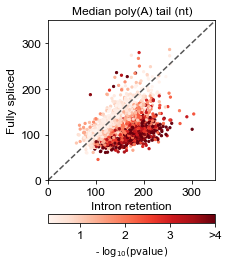

In [437]:
# CR-APA

plt.figure(figsize=(3, 4.2))
plt.scatter(
    x=spliced_polya['unspliced_polya_len'], 
    y=spliced_polya['spliced_polya_len'], 
    s=5, 
    c=-np.log10(spliced_polya['p_value']),
    cmap=plt.cm.get_cmap('Reds'),
    vmax=4
)
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.plot([0, 350], [0, 350], color='#555555', ls='--')
plt.xlabel('Intron retention')
plt.ylabel('Fully spliced')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar(orientation="horizontal")
colorbar.set_ticks([1, 2, 3, 4])
colorbar.set_ticklabels([1, 2, 3, '>4'])
colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$", size='small')
plt.title('Median poly(A) tail (nt)', size='medium')

In [172]:
# Calculate the point density
xy = np.vstack([spliced_polya['unspliced_polya_len'], spliced_polya['spliced_polya_len']])
color = gaussian_kde(xy)(xy)

10/26/2020 08:37:37 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b059f4e9e90>
10/26/2020 08:37:37 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b059f4e9e90> on colorbar
10/26/2020 08:37:37 PM colorbar.py: Setting pcolormesh


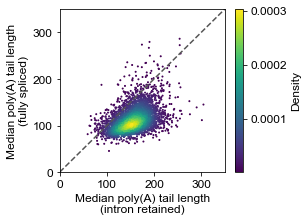

In [173]:
plt.figure(figsize=(3.7, 3))
plt.scatter(x=spliced_polya['unspliced_polya_len'], y=spliced_polya['spliced_polya_len'], s=1, c=color)
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.plot([0, 350], [0, 350], color='#555555', ls='--')
plt.xlabel('Median poly(A) tail length\n(intron retained)')
plt.ylabel('Median poly(A) tail length\n(fully spliced)')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar()
colorbar.set_label("Density")

In [490]:
df1 = pd.DataFrame(spliced_polya['unspliced_polya_len'].values, columns=['polya_len'])
df1['type'] = 'IR'
df2 = pd.DataFrame(spliced_polya['spliced_polya_len'].values, columns=['polya_len'])
df2['type'] = 'spliced'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 0, '')

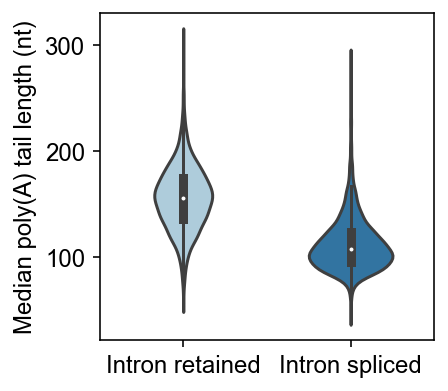

In [491]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
plt.ylabel('Median poly(A) tail length (nt)')
plt.xticks([0, 1], ['Intron retained', 'Intron spliced'])
plt.xlabel('')

In [383]:
print(f'IR polya length = {np.median(spliced_polya["unspliced_polya_len"]):.2f}')
print(f'Fully spliced polya length = {np.median(spliced_polya["spliced_polya_len"]):.2f}')

IR polya length = 155.47
Fully spliced polya length = 107.33


In [382]:
mannwhitneyu(spliced_polya["unspliced_polya_len"], spliced_polya["spliced_polya_len"])

MannwhitneyuResult(statistic=2212254.5, pvalue=0.0)

## single gene

In [492]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
gene_id = 'AT5G67110'
unspliced_polya_len, spliced_polya_len, gene_id = get_IR_read_polya_len(infile, gene_id, mode='raw')

In [493]:
df1 = pd.DataFrame(unspliced_polya_len, columns=['polya_len'])
df1['type'] = 'IR'
df2 = pd.DataFrame(spliced_polya_len, columns=['polya_len'])
df2['type'] = 'spliced'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 0, '')

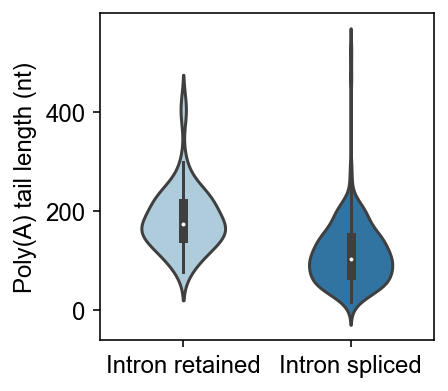

In [494]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
plt.ylabel('Poly(A) tail length (nt)')
plt.xticks([0, 1], ['Intron retained', 'Intron spliced'])
plt.xlabel('')

In [415]:
print(f'IR polya length = {np.median(unspliced_polya_len):.2f}, n={len(unspliced_polya_len)}')
print(f'Fully spliced polya length = {np.median(spliced_polya_len):.2f}, n={len(spliced_polya_len)}')

IR polya length = 173.06, n=59
Fully spliced polya length = 104.08, n=191


In [416]:
mannwhitneyu(unspliced_polya_len, spliced_polya_len)

MannwhitneyuResult(statistic=2066.5, pvalue=1.0051995707555749e-13)

# polya tail length in ES

In [417]:
ES_stats = namedtuple('ES_stats', 'exon_total_count exon_count skipped_exon_count skipped_exon')

es_stats_pkl = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bed.es_stats.tsv.pkl'

with open(es_stats_pkl, 'rb') as f:
    es_stats_dict = pickle.load(f)

In [418]:
es_stats_dict['7630665e-c2ca-4b8d-a6d7-2240d68f8844']

{'AT1G01010': ES_stats(exon_total_count=6, exon_count=6, skipped_exon_count=0, skipped_exon='')}

In [419]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_ES_read_polya_len(infile, gene_id, mode='median'):
    '''
    获取同一基因不同剪切状态的polya长度
        fully_spliced
        exon skipped
    '''
    chrom, start, end, _, gene_strand = gene_model.loc[gene_id, :].values
    gene_strand = STRAND_TO_BOOL[gene_strand]
    es_polya_len, non_skipped_polya_len = [], []

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end):
            try:
                _, intron_count, unspliced_count, unspliced_intron  = ir_stats_dict[read.query_name][gene_id]
                exon_total_count, exon_count, skipped_exon_count, _ = es_stats_dict[read.query_name][gene_id]
                if intron_count == 0:
                    # 转录还没有过第一个exon的情况
                    # 忽略
                    continue
            except KeyError:
                continue
                
            if unspliced_count > 0:
                continue
                
            polya_len = read.get_tag('pa')
            read_gene_id = read.get_tag('gi')
            
            if read_gene_id != gene_id:
                continue
            
            if skipped_exon_count == 0:
                non_skipped_polya_len.append(polya_len)
            else:
                es_polya_len.append(polya_len)
            
        if len(es_polya_len) >= 5 and len(non_skipped_polya_len) >= 5:
            if mode == 'median':
                es_count = len(es_polya_len)
                non_skipped_count = len(non_skipped_polya_len)
                p_value = mannwhitneyu(es_polya_len, non_skipped_polya_len)
                es_polya_len = np.median(es_polya_len)
                non_skipped_polya_len = np.median(non_skipped_polya_len)
                return es_polya_len, es_count, non_skipped_polya_len, non_skipped_count, p_value[1], gene_id

            elif mode == 'raw':
                return es_polya_len, non_skipped_polya_len, gene_id
            

In [420]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
gene_id = 'AT3G23280'
get_ES_read_polya_len(infile, gene_id)

(121.18999862670898,
 30,
 129.64999389648438,
 35,
 0.43467352636371753,
 'AT3G23280')

In [421]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'

results = []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id in gene_model.index:
        results.append(e.submit(get_ES_read_polya_len, infile, gene_id))

In [422]:
es_stats_polya = []
for res in results:
    result = res.result()
    if result is not None:
        es_stats_polya.append(result)

In [423]:
es_stats_polya = pd.DataFrame(
    es_stats_polya, 
    columns=['es_polya_len', 'es_count', 'non_skipped_polya_len', 'non_skipped_count', 'p_value', 'gene_id']
)

In [471]:
es_stats_polya['color'] = es_stats_polya['p_value'].map(lambda x: 1 if x < .01 else 0)

In [472]:
es_stats_polya

,es_polya_len,es_count,non_skipped_polya_len,non_skipped_count,p_value,gene_id,color
0,82.670002,1880,57.970001,15,0.010939,AT1G01100,0
1,58.970001,9,109.230000,16,0.001016,AT1G03365,1
2,142.619995,5,103.200001,224,0.044936,AT1G03475,0
3,169.490005,5,159.445000,6,0.392096,AT1G05900,0
4,104.839996,5,91.239998,31,0.192392,AT1G06500,0
...,...,...,...,...,...,...,...
196,158.489998,14,117.280003,18,0.157051,AT5G65740,0
197,143.850006,5,100.820000,740,0.131425,AT5G66190,0
198,86.834999,6,80.519997,5871,0.287221,AT5G66570,0
199,68.510002,7,104.424999,184,0.032701,AT5G67110,0


Text(0.5, 1.0, 'Median poly(A) tail (nt)')

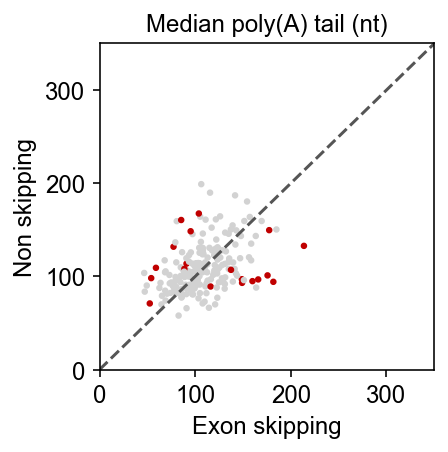

In [475]:
# CR-APA

plt.figure(figsize=(3, 3))
plt.scatter(
    x=es_stats_polya['es_polya_len'], 
    y=es_stats_polya['non_skipped_polya_len'], 
    s=5, 
    c=es_stats_polya['color'],
    cmap=mpl.colors.ListedColormap(['#D2D2D2', '#C00000']),
)
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.plot([0, 350], [0, 350], color='#555555', ls='--')
plt.xlabel('Exon skipping')
plt.ylabel('Non skipping')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

plt.title('Median poly(A) tail (nt)', size='medium')

11/05/2020 07:28:06 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b04711d71d0>
11/05/2020 07:28:06 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b04711d71d0> on colorbar
11/05/2020 07:28:06 PM colorbar.py: Setting pcolormesh


Text(0.5, 1.0, 'Median poly(A) tail (nt)')

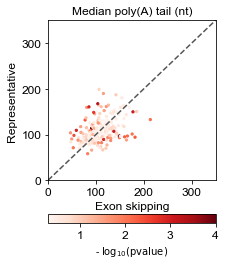

In [443]:
# CR-APA

plt.figure(figsize=(3, 4.2))
plt.scatter(
    x=es_stats_polya['es_polya_len'], 
    y=es_stats_polya['non_skipped_polya_len'], 
    s=5, 
    c=-np.log10(es_stats_polya['p_value']),
    cmap=plt.cm.get_cmap('Reds'),
    vmax=4,
)
plt.xlim(0, 350)
plt.ylim(0, 350)
plt.plot([0, 350], [0, 350], color='#555555', ls='--')
plt.xlabel('Exon skipping')
plt.ylabel('Representative')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar(orientation="horizontal")
# colorbar.set_ticks([1, 2, 3, 4])
# colorbar.set_ticklabels([1, 2, 3, '>4'])
colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$", size='small')
plt.title('Median poly(A) tail (nt)', size='medium')

In [375]:
# Calculate the point density
xy = np.vstack([es_stats_polya['es_polya_len'], es_stats_polya['non_skipped_polya_len']])
color = gaussian_kde(xy)(xy)

10/27/2020 03:00:29 PM colorbar.py: locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b04815b2790>
10/27/2020 03:00:29 PM colorbar.py: Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b04815b2790> on colorbar
10/27/2020 03:00:29 PM colorbar.py: Setting pcolormesh


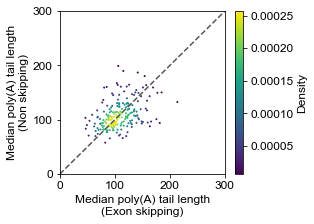

In [377]:
plt.figure(figsize=(3.7, 3))
plt.scatter(x=es_stats_polya['es_polya_len'], y=es_stats_polya['non_skipped_polya_len'], s=1, c=color)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Median poly(A) tail length\n(Exon skipping)')
plt.ylabel('Median poly(A) tail length\n(Non skipping)')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar()
colorbar.set_label("Density")

In [477]:
df1 = pd.DataFrame(es_stats_polya['es_polya_len'].values, columns=['polya_len'])
df1['type'] = 'exon skipped'
df2 = pd.DataFrame(es_stats_polya['non_skipped_polya_len'].values, columns=['polya_len'])
df2['type'] = 'non skipped'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 0, '')

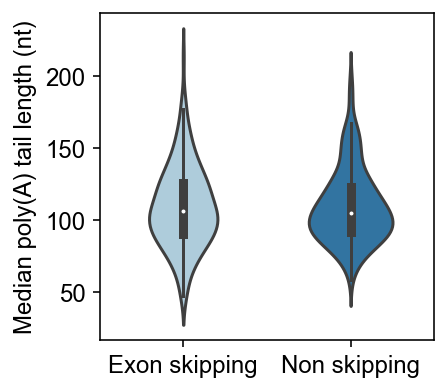

In [478]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
plt.ylabel('Median poly(A) tail length (nt)')
plt.xticks([0, 1], ['Exon skipping', 'Non skipping'])
plt.xlabel('')

In [381]:
print(f'exon skipping polya length = {np.median(es_stats_polya["es_polya_len"]):.2f}')
print(f'non skipping polya length = {np.median(es_stats_polya["non_skipped_polya_len"]):.2f}')

exon skipping polya length = 105.97
non skipping polya length = 104.88


In [308]:
mannwhitneyu(es_stats_polya["es_polya_len"], es_stats_polya["non_skipped_polya_len"])

MannwhitneyuResult(statistic=12304.5, pvalue=0.4903297404784615)

## single gene

In [486]:
infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.full_len.bam'
gene_id = 'AT1G07780'
gene_id = 'AT1G52220'
gene_id = 'AT3G23280'
es_polya_len, non_skipped_polya_len, gene_id = get_ES_read_polya_len(infile, gene_id, mode='raw')

In [487]:
df1 = pd.DataFrame(es_polya_len, columns=['polya_len'])
df1['type'] = 'ES'
df2 = pd.DataFrame(non_skipped_polya_len, columns=['polya_len'])
df2['type'] = 'Non-ES'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 0, '')

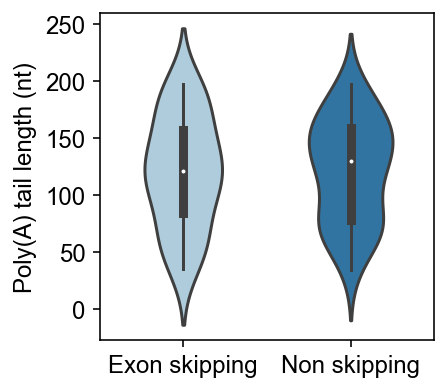

In [488]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
plt.ylabel('Poly(A) tail length (nt)')
plt.xticks([0, 1], ['Exon skipping', 'Non skipping'])
plt.xlabel('')

In [389]:
print(f'exon skipped polya length = {np.median(es_polya_len):.2f}, n={len(es_polya_len)}')
print(f'non exon skipped polya length = {np.median(non_skipped_polya_len):.2f}, n={len(non_skipped_polya_len)}')

exon skipped polya length = 121.19, n=30
non exon skipped polya length = 129.65, n=35


In [374]:
mannwhitneyu(es_polya_len, non_skipped_polya_len)

MannwhitneyuResult(statistic=512.0, pvalue=0.43467352636371753)